In [1]:
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

C:\Users\Amr osama abdellatif\AppData\Local\Temp\ipykernel_15804\281702299.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
batch_size = 100

x_dim  = 784 # 28*28 mnist image
hidden_dim = 400  # intermediate layer size
latent_dim = 150 # latent layer size Z

In [3]:
train_dataset = MNIST("./", transform=transforms.ToTensor(), train=True, download=True)
test_dataset  = MNIST("./", transform=transforms.ToTensor(), train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

In [4]:
# lets take a look at the dataloader
x,y = next(iter(train_loader))
x.shape , y.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [6]:
"""
1. encoder dimensionality for input image
        784 -> 400 -> 200 -> 150 -> 2
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.model_before_mean_var = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim//2,latent_dim),
            nn.LeakyReLU(0.2),
        )

        self.mean = nn.Linear(latent_dim,2)

        self.log_var = nn.Linear(latent_dim,2)
        
    def forward(self, x):
        x1 = self.model_before_mean_var(x) 
        mean = self.mean(x1)
        log_var = self.log_var(x1)

        """
        The standard deviation (σ) 
        is obtained by exponentiating half of the 
        logarithm of the variance: σ = exp(0.5 * log(σ^2)). 
        This is done to ensure that the standard deviation is always positive.

        So, in summary, in the context of a VAE:

        1. μ is the mean of the latent distribution.
        2. log(σ^2) is the logarithm of the variance of the latent distribution.
        3. σ = exp(0.5 * log(σ^2)) is the standard deviation of the latent distribution.
        """

        # encoder produces mean and log of variance
        return mean, log_var

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()


        self.model_after_sampling = nn.Sequential(
            nn.Linear(2,latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim//2,hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim,output_dim)
        )

    def forward(self, x):
        x1 = self.model_after_sampling(x)
        
        x_reconstructed = torch.sigmoid(x1)
        return x_reconstructed
        

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(DEVICE)
        eps = torch.randn_like(std)
        
        # epsilon = torch.randn_like(standardDeviation).to(DEVICE)        # sampling epsilon        
        z = mean + std * eps                          # reparameterization trick
        return z
        """sampling here is done based on epislon where it lies 
        in specific range [0,1] randomly distributed"""

                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        '''The expression torch.exp(0.5 * log_var) is used to
        compute the standard deviation (σ) from the logarithm of the variance (log_var)'''
        z = self.reparameterization(mean, log_var) 
        x_reconstructed = self.Decoder(z)
        
        return x_reconstructed, mean, log_var

In [9]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [10]:
def loss_function(x, x_reconstructed, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [11]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
epochs = 7
print("Start training VAE...")
model.train()

for epoch in tqdm(range(epochs),desc="Epoch"):
    overall_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader),desc="Batch"):  # throwing labels away
        x = x.reshape(batch_size, x_dim) # reshape into (100,784) because model is expecting (784) input feature
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_reconstructed, mean, log_var = model(x)
        loss = loss_function(x,x_reconstructed, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    # print(f"\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    print(f"Epoch : {epoch +1} | complete | average Loss : {overall_loss / (batch_idx*batch_size)} ")


print("Finish!!")

Start training VAE...


Batch: 600it [00:11, 50.85it/s]:00<?, ?it/s]
Epoch:  14%|█▍        | 1/7 [00:11<01:10, 11.80s/it]

Epoch : 1 | complete | average Loss : 184.54448524233098 


Batch: 600it [00:08, 66.74it/s]
Epoch:  29%|██▊       | 2/7 [00:20<00:50, 10.15s/it]

Epoch : 2 | complete | average Loss : 160.65093937486958 


Batch: 600it [00:09, 64.16it/s]
Epoch:  43%|████▎     | 3/7 [00:30<00:39,  9.79s/it]

Epoch : 3 | complete | average Loss : 154.8878663169084 


Batch: 600it [00:09, 66.03it/s]
Epoch:  57%|█████▋    | 4/7 [00:39<00:28,  9.51s/it]

Epoch : 4 | complete | average Loss : 151.87119634612375 


Batch: 600it [00:07, 80.47it/s]
Epoch:  71%|███████▏  | 5/7 [00:46<00:17,  8.77s/it]

Epoch : 5 | complete | average Loss : 149.61729345458576 


Batch: 600it [00:06, 85.91it/s]
Epoch:  86%|████████▌ | 6/7 [00:53<00:08,  8.17s/it]

Epoch : 6 | complete | average Loss : 148.13611137377399 


Batch: 600it [00:06, 87.33it/s]
Epoch: 100%|██████████| 7/7 [01:00<00:00,  8.65s/it]

Epoch : 7 | complete | average Loss : 147.22054672827107 
Finish!!


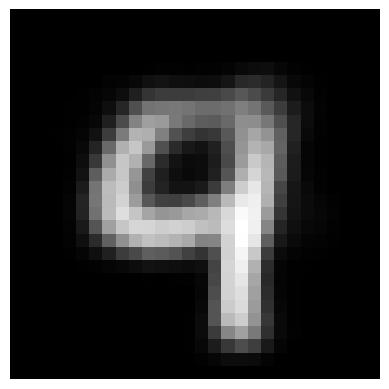

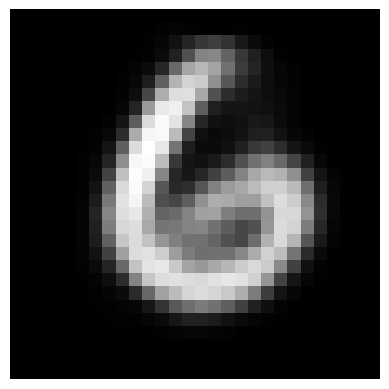

(None, None)

In [13]:
import matplotlib.pyplot as plt

def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float32).to(DEVICE)


    with torch.inference_mode():
        x_decoded = model.Decoder(z_sample)
        digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [14]:

def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.Decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


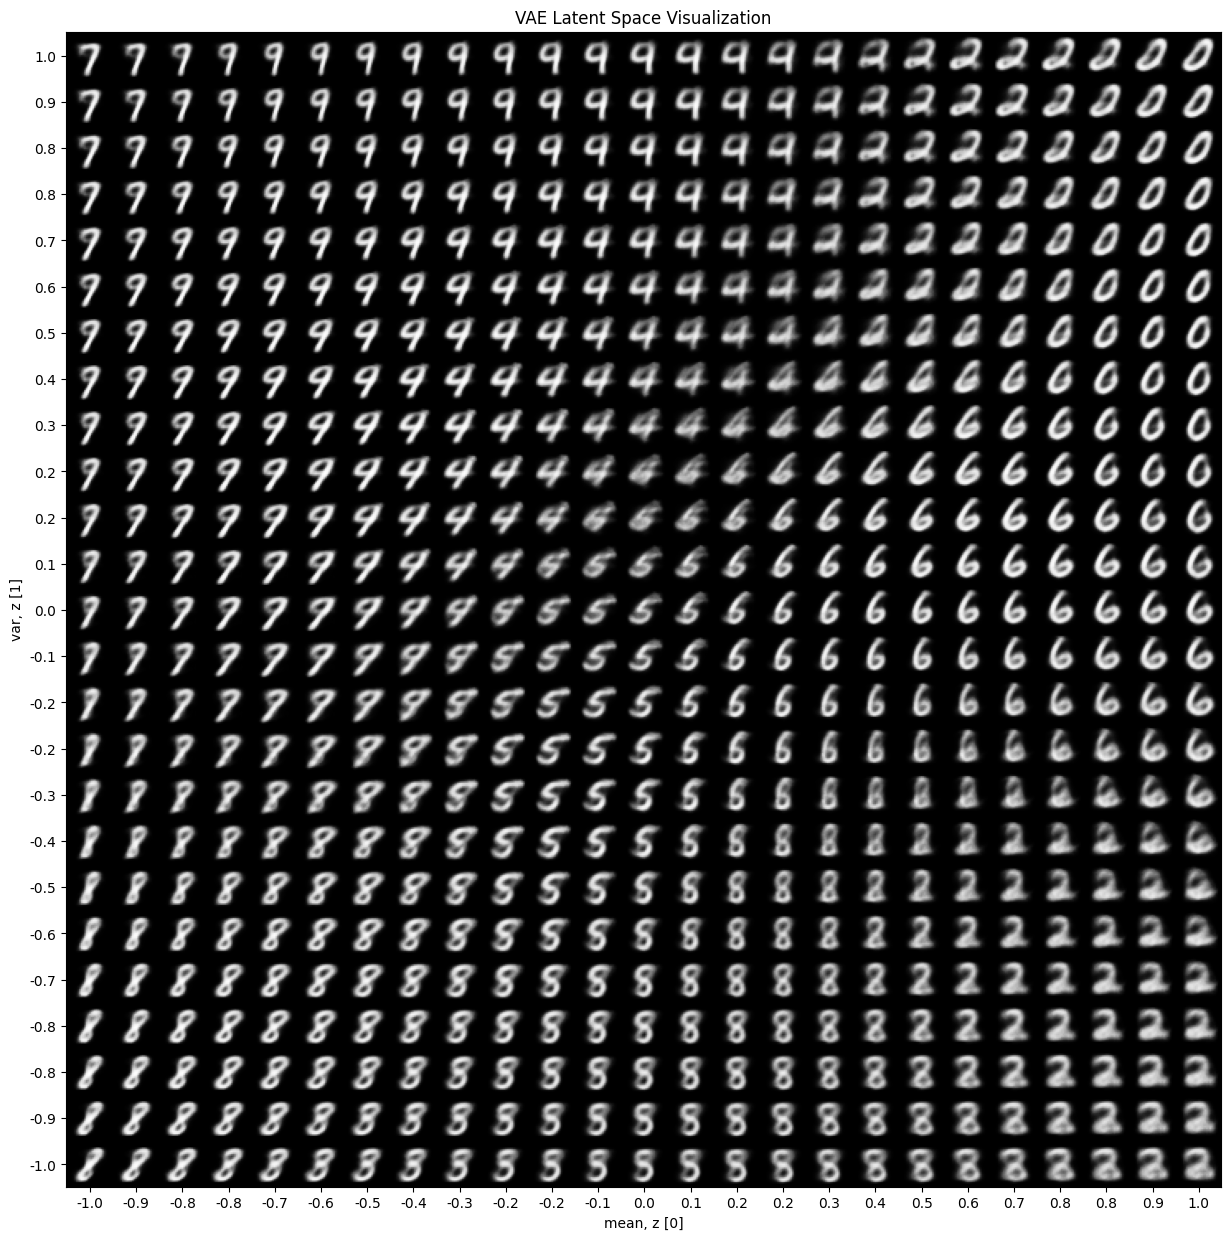

In [15]:
# Lets take a look at the Latent Space 
plot_latent_space(model, scale=1.0)